<a href="https://colab.research.google.com/github/arnavaj23/Multivariate_timeseries_forecasting/blob/main/LSTM/MicrosoftStocks/Microsoft_Stock_Forecasting_with_LSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# dataset @ https://finance.yahoo.com/quote/MSFT/history/

In [2]:
!pip install yfinance

In [3]:
import yfinance as yf

data = yf.download("MSFT", start="2000-01-01", end="2025-06-27")
data.to_csv("microsoft_stock_data.csv")
print("CSV file saved as 'microsoft_stock_data.csv'")

/tmp/ipython-input-3-3387249390.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("MSFT", start="2000-01-01", end="2025-06-27")
[*********************100%***********************]  1 of 1 completed

CSV file saved as 'microsoft_stock_data.csv'


In [4]:
import pandas as pd

In [5]:
df = pd.read_csv("microsoft_stock_data.csv")

In [6]:
df.head()

,Price,Close,High,Low,Open,Volume
0,Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
1,Date,NaN,NaN,NaN,NaN,NaN
2,2000-01-03,35.72672653198242,36.35888844917031,34.32830774547587,35.97576001451098,53228400
3,2000-01-04,34.519866943359375,35.899129107577956,34.4049284296745,34.80721322757158,54119000
4,2000-01-05,34.88383865356445,35.66925182478694,33.523732918032835,34.060112644721364,64059600


In [7]:
df = df.drop([0, 1])

df = df.rename(columns={'Price': 'Date'})

In [8]:
df.head()

,Date,Close,High,Low,Open,Volume
2,2000-01-03,35.72672653198242,36.35888844917031,34.32830774547587,35.97576001451098,53228400
3,2000-01-04,34.519866943359375,35.899129107577956,34.4049284296745,34.80721322757158,54119000
4,2000-01-05,34.88383865356445,35.66925182478694,33.523732918032835,34.060112644721364,64059600
5,2000-01-06,33.715293884277344,34.90299173701893,33.217227042805064,34.38576847856695,54976600
6,2000-01-07,34.15589904785156,34.40493252380337,32.891575246865465,33.29386009263377,62013600


In [9]:
df = df[['Date','Close']]
display(df)

,Date,Close
2,2000-01-03,35.72672653198242
3,2000-01-04,34.519866943359375
4,2000-01-05,34.88383865356445
5,2000-01-06,33.715293884277344
6,2000-01-07,34.15589904785156
...,...,...
6406,2025-06-20,477.3999938964844
6407,2025-06-23,486.0
6408,2025-06-24,490.1099853515625
6409,2025-06-25,492.2699890136719


In [10]:
df['Date']

,Date
2,2000-01-03
3,2000-01-04
4,2000-01-05
5,2000-01-06
6,2000-01-07
...,...
6406,2025-06-20
6407,2025-06-23
6408,2025-06-24
6409,2025-06-25


In [11]:
import datetime

def str_to_datetime(s):
  split  = s.split('-')
  year = int(split[0])
  month = int(split[1])
  day = int(split[2])
  return datetime.datetime(year, month, day)

df['Date'] = df['Date'].apply(str_to_datetime)

In [12]:
df['Date']

,Date
2,2000-01-03
3,2000-01-04
4,2000-01-05
5,2000-01-06
6,2000-01-07
...,...
6406,2025-06-20
6407,2025-06-23
6408,2025-06-24
6409,2025-06-25


In [13]:
df = df.set_index('Date')

In [14]:
df.head()

,Close
Date,
2000-01-03,35.72672653198242
2000-01-04,34.519866943359375
2000-01-05,34.88383865356445
2000-01-06,33.715293884277344
2000-01-07,34.15589904785156


In [15]:
df['Close'] = pd.to_numeric(df['Close'])

<Axes: xlabel='Date'>

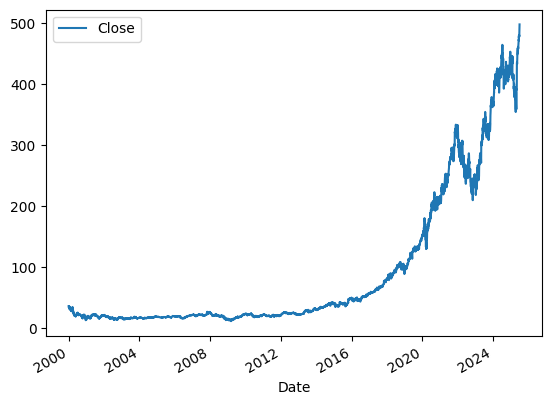

In [16]:
df.plot()

In [17]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

windowed_df = df_to_windowed_df(df,
                                '2021-03-25',
                                '2023-08-01',
                                n=50)
windowed_df

,Target Date,Target-50,Target-49,Target-48,Target-47,Target-46,Target-45,Target-44,Target-43,Target-42,...,Target-9,Target-8,Target-7,Target-6,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,2021-03-25,206.959503,208.317230,205.120377,204.764069,208.413559,216.020569,216.627213,217.570877,221.018127,...,227.530304,226.623047,229.421967,228.775284,222.675674,222.318573,227.761932,229.296509,227.250427,224.239151
1,2021-03-26,208.317230,205.120377,204.764069,208.413559,216.020569,216.627213,217.570877,221.018127,223.714294,...,226.623047,229.421967,228.775284,222.675674,222.318573,227.761932,229.296509,227.250427,224.239151,228.234818
2,2021-03-29,205.120377,204.764069,208.413559,216.020569,216.627213,217.570877,221.018127,223.714294,224.263138,...,229.421967,228.775284,222.675674,222.318573,227.761932,229.296509,227.250427,224.239151,228.234818,227.038086
3,2021-03-30,204.764069,208.413559,216.020569,216.627213,217.570877,221.018127,223.714294,224.263138,230.069550,...,228.775284,222.675674,222.318573,227.761932,229.296509,227.250427,224.239151,228.234818,227.038086,223.766281
4,2021-03-31,208.413559,216.020569,216.627213,217.570877,221.018127,223.714294,224.263138,230.069550,223.357971,...,222.675674,222.318573,227.761932,229.296509,227.250427,224.239151,228.234818,227.038086,223.766281,227.549591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,2023-07-26,303.575592,304.057007,306.297180,309.192169,313.642975,313.465729,316.262329,310.432953,309.044495,...,337.413361,339.953827,340.436371,353.985657,349.643158,341.558929,338.506378,339.825836,345.606018,332.598206
588,2023-07-27,304.057007,306.297180,309.192169,313.642975,313.465729,316.262329,310.432953,309.044495,320.929718,...,339.953827,340.436371,353.985657,349.643158,341.558929,338.506378,339.825836,345.606018,332.598206,325.656189
589,2023-07-28,306.297180,309.192169,313.642975,313.465729,316.262329,310.432953,309.044495,320.929718,327.793030,...,340.436371,353.985657,349.643158,341.558929,338.506378,339.825836,345.606018,332.598206,325.656189,333.189026
590,2023-07-31,309.192169,313.642975,313.465729,316.262329,310.432953,309.044495,320.929718,327.793030,326.138641,...,353.985657,349.643158,341.558929,338.506378,339.825836,345.606018,332.598206,325.656189,333.189026,330.776581


In [18]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((592,), (592, 50, 1), (592,))

In [19]:
import matplotlib.pyplot as plt

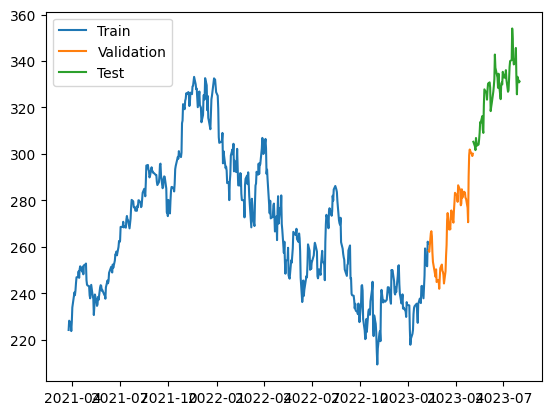

In [20]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from keras.optimizers import Adam

import tensorflow as tf

model = Sequential([layers.Input((50, 1)),
                    layers.LSTM(256, return_sequences=True),
                    layers.LSTM(128, return_sequences=True),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(16, activation='relu'),
                    layers.Dense(1)])


model.compile(
    loss=tf.keras.losses.Huber(delta=1.0),
    optimizer=Adam(learning_rate=0.001),
    metrics=['mae', 'mape']  # Mean Absolute Error & Mean Absolute Percentage Error
)

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 357ms/step - loss: 267.2619 - mae: 267.7619 - mape: 99.6680 - val_loss: 265.3011 - val_mae: 265.8011 - val_mape: 98.4887
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - loss: 261.1721 - mae: 261.6721 - mape: 97.9793 - val_loss: 259.9186 - val_mae: 260.4186 - val_mape: 96.4863
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 300ms/step - loss: 255.3439 - mae: 255.8439 - mape: 95.8816 - val_loss: 253.6668 - val_mae: 254.1668 - val_mape: 94.1604
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - loss: 247.3463 - mae: 247.8463 - mape: 93.2662 - val_loss: 244.7542 - val_mae: 245.2542 - val_mape: 90.8446
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - loss: 240.0676 - mae: 240.5676 - mape: 89.6638 - val_loss: 232.4729 - val_mae: 232.9729 - val_mape: 86.2755
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 247ms/step - loss: 226.4034 - mae: 226.9034 - mape: 84.6162 - val_loss: 215.9287 - val_mae: 216.4287 - val_mape: 80.1204
Epoch 7/100
15/15 ━━━

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step


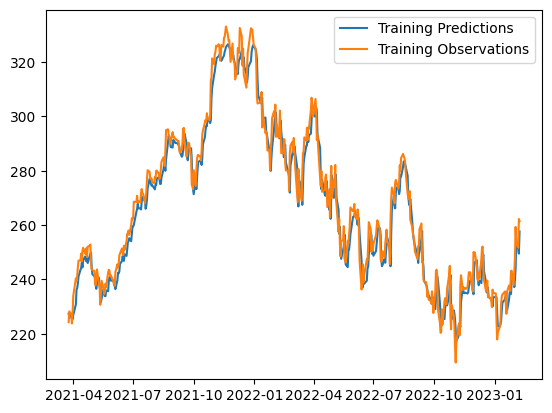

In [22]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


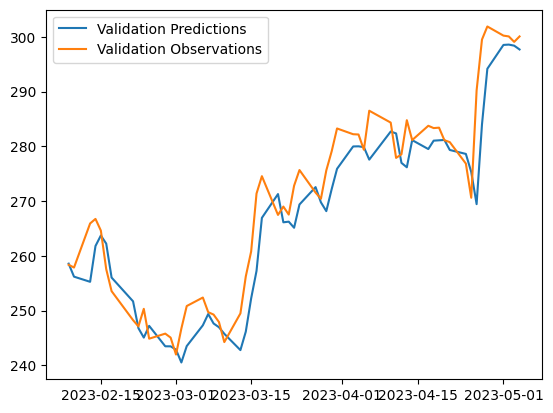

In [23]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


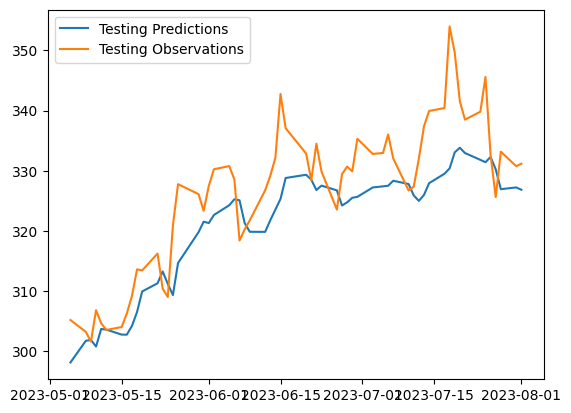

In [24]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

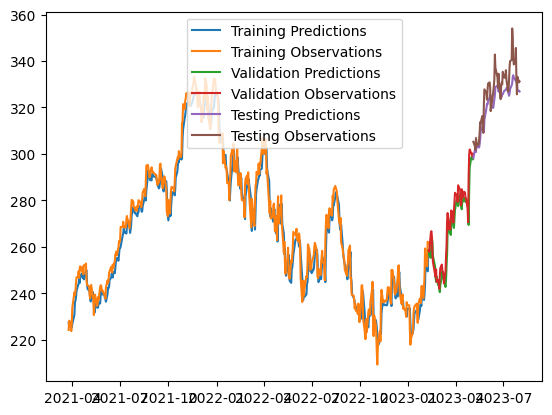

In [25]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [26]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# R² Score
r2 = r2_score(y_test, test_predictions)
print(f'R² Score: {r2:.4f}')

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print(f'RMSE: {rmse:.4f}')

# MAE
mae = mean_absolute_error(y_test, test_predictions)
print(f'MAE: {mae:.4f}')

# MAPE
mape = np.mean(np.abs((y_test - test_predictions) / y_test)) * 100
print(f'MAPE: {mape:.2f}%')


R² Score: 0.6219
RMSE: 7.5875
MAE: 6.0742
MAPE: 1.83%


In [27]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━

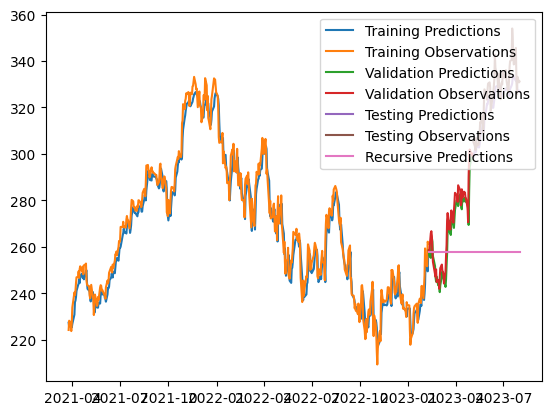

In [28]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])